In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import chi2
from scipy import constants

#Graphing variables
pagewidth = (8.5, 5)

In [3]:
#Function definitions

''' Plots the distributions of data as a histogram against the gaussian distribution with mean and stddev matching
    that of the data. 
'''
def plot_distribution(data, filename, title, figsize=pagewidth, bins='sturges', hrange=(-100, 100), 
                      directory='graphs/distributions/', logmode=False):
    plt.figure(figsize=figsize)
    if (hrange == (-100, 100)): hrange = (min(data), max(data))
    gspace = np.linspace(hrange[0], hrange[1], 1000)
    gnorm = norm.pdf(gspace, loc=np.mean(data), scale=np.std(data))
    if type(bins) is str: bins = len(np.histogram_bin_edges(data, bins=bins)) - 1
    gnorm *= 1000 * len(data) / (sum(gnorm) * bins)
    plt.plot(gspace, gnorm, color='orange', label='Normal Distribution')
    plt.hist(data, bins=bins, range=hrange, facecolor='blue', alpha=0.5, label='ADC Distribution')
    plt.xlabel('ADC Reading (bits)')
    plt.ylabel('Number of Samples')
    if logmode: plt.yscale('log')
    plt.title('Distribution of Data, with frequency '+title+', # bins='+str(bins))
    plt.legend()
    plt.savefig(directory+filename+'.png', bbox_inches='tight')

''' Sums n adjacent samples together in list data and returns a new list of size len(data)/n. 
    n should be a factor of len(data).
'''
def sum_adjacent(data, n):
    return np.sum(data.reshape(int(len(data)/n), -1), axis=1)

In [56]:
%%time
#CPU times: user 380 ms, sys: 442 ms, total: 822 ms Wall time: 11.4 s
#CPU times: user 1.31 s, sys: 3.61 s, total: 4.91 sWall time: 40 s (just loading two sets)

#Load data, subtract mean
#Ended up being much faster this way then using an array

room_fm = np.fromfile('newdata/room_FM_100m.dat', dtype='int16')-2.**11 
room_fm -= np.mean(room_fm)
dry_ice = np.fromfile('newdata/dry_ice.dat', dtype='int16')-2.**11 
dry_ice -= np.mean(dry_ice)

CPU times: user 1.31 s, sys: 3.61 s, total: 4.91 s
Wall time: 40 s


In [5]:
#Title strings for graphing
filenames = ['room_UHF_100m', 'room_FM_100m', 'room_LTE_100m', 
             'boiling', #'boiling2', 'boiling3', 'boiling4',
             'ice', 'dry_ice', 'liquid_nitrogen']
titles = ['1GHz @21.9$^\circ$ C', '100MHz @21.9$^\circ$ C', '720MHz @21.9$^\circ$ C', 
          '1GHz @87.2$^\circ$ C', #'1GHz @77.1$^\circ$ C', '1GHz @61.8$^\circ$ C', '1GHz @56.6$^\circ$ C', 
          '1GHz @0.8$^\circ$ C', '1GHz @-78.5$^\circ$ C', '1GHz @-195.8$^\circ$ C']

CPU times: user 20.5 s, sys: 690 ms, total: 21.2 s
Wall time: 21.2 s


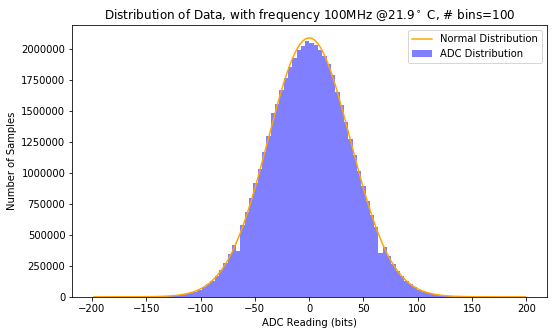

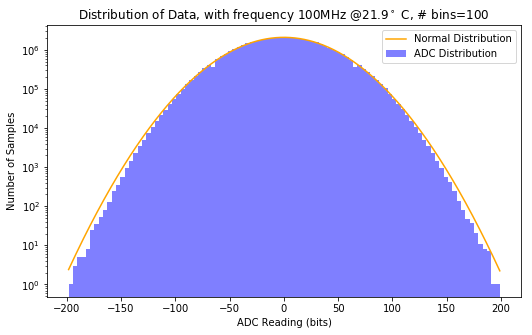

In [5]:
%%time
#CPU times: user 19.6 s, sys: 615 ms, total: 20.2 s Wall time: 19.8 s

#Distribution graphs
plot_distribution(room_fm[50000000:], filenames[1], titles[1], bins=100)
plot_distribution(room_fm[50000000:], filenames[1]+'log-y', titles[1], logmode=True, bins=100)

In [57]:
%%time
#CPU times: user 286 ms, sys: 240 ms, total: 525 ms Wall time: 525 ms

#Calculate power lists
constant = constants.epsilon_0 * constants.c / 2
power_fm = constant * room_fm**2
power_di = constant * dry_ice**2

CPU times: user 749 ms, sys: 2.11 s, total: 2.86 s
Wall time: 4.12 s


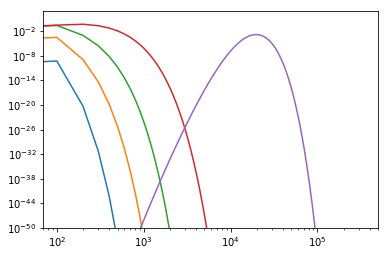

In [107]:
num = np.array([1, 2, 4, 10, 100])
cspace = np.linspace(0,1000000,10000)
for i in range(len(num)):
    plt.plot(cspace, 10**3/num[i] * chi2.pdf(cspace, num[i], loc=num[i], scale=2*num[i]))
plt.xscale('log')
plt.yscale('log')
plt.xlim((7*10**1,5*10**5))
plt.ylim((10**(-50),10**3))
plt.show()

check0
check1
check2
check3
check4
CPU times: user 49.6 s, sys: 1.07 s, total: 50.6 s
Wall time: 50.6 s


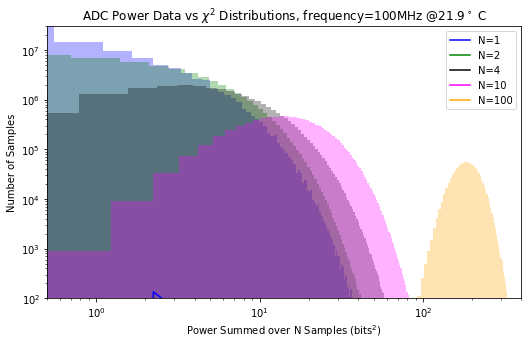

In [88]:
%%time
#CPU times: user 43.2 s, sys: 5.98 s, total: 49.2 s Wall time: 1min 12s

#CPU times: user 39.5 s, sys: 1.53 s, total: 41 s Wall time: 41.7 s
#CPU times: user 1min 1s, sys: 5.79 s, total: 1min 7s Wall time: 1min 35s with norm
#CPU times: user 59.1 s, sys: 2.91 s, total: 1min 1s Wall time: 1min 16s with multiplied by norm
#CPU times: user 54.7 s, sys: 6.83 s, total: 1min 1s Wall time: 2min 25s
#CPU times: user 1min 45s, sys: 8.3 s, total: 1min 54s Wall time: 2min 51s for two graphs

def plot_chi2(power, filename, title, num_bins=200, samples=100, directory='graphs/chi2/'):
    num = np.array([1, 2, 4, 10, 100])
    colours = ['blue', 'green', 'black', 'magenta', 'orange']
    plt.figure(figsize=pagewidth)
    plist, cspace, clist = [], [], []
    mean, std = np.mean(power), np.std(power)
    length, sump = len(power), sum(power)
    for i in range(len(num)): 
        plist.append(sum_adjacent(power, num[i]))
        cspace.append(np.linspace(min(plist[i]), max(plist[i]), samples))
        #cnorm = samples * length * sump/(sump * num_bins * num[i])
        clist.append(295.05/num[i] * chi2.pdf(cspace[i], num[i], loc=num[i]*mean, scale=2*num[i]))
        print('check'+str(i))
    for i in range(len(plist)): 
        plt.hist(plist[i], bins=200, color=colours[i], alpha=0.3)
        plt.plot(cspace[i], clist[i], color=colours[i], label='N='+str(num[i]))
    plt.xlabel('Power Summed over N Samples (bits$^2$)')
    plt.ylabel('Number of Samples')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim((5*10**(-1), 4*10**2))
    plt.ylim((10**2, 3*10**7))
    plt.title('ADC Power Data vs $\chi^2$ Distributions, frequency='+title)
    plt.legend()
    plt.savefig(directory+filename+'.png', bbox_inches='tight')

plot_chi2(power_fm, filenames[1], titles[1])
#plot_chi2(power_di, filenames[5], titles[5])

mean 1910.5463213128291
std 140.9565413332815
time 20
bandwidth 2e-15
ratio 1.0
ratio 0.0001414213562373095
CPU times: user 2.34 s, sys: 196 ms, total: 2.54 s
Wall time: 2.13 s


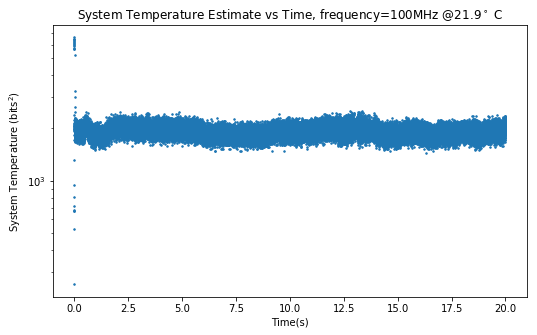

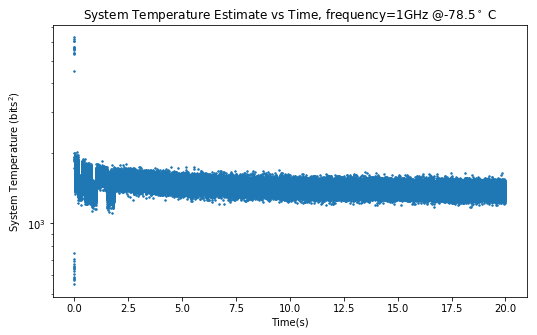

In [61]:
%%time
#CPU times: user 2.34 s, sys: 196 ms, total: 2.54 s Wall time: 2.13 s

temp_fm = sum_adjacent(power_fm,1000)
temp_di = sum_adjacent(power_di,1000)

def plot_temp(temp, filename, title, directory='graphs/temperatures/'):
    plt.figure(figsize=pagewidth)
    plt.scatter(np.arange(len(temp))/5000, temp , s=1.5**2)
    plt.xlabel('Time(s)')
    plt.ylabel('System Temperature (bits$^2$)')
    plt.yscale('log')
    plt.title('System Temperature Estimate vs Time, frequency='+title)
    plt.savefig(directory+filename+'.png', bbox_inches='tight')
    
plot_temp(temp_fm, filenames[1], titles[1])
plot_temp(temp_di, filenames[5], titles[5])

cadence = 20/(100*10**6)
print('mean',np.mean(temp_fm))
print('std',np.std(temp_fm))
print('time',20)
print('bandwidth',1/(500*10**12))
print('ratio',1/np.sqrt(20*1/(100*10**6 * cadence)))
print('ratio',np.sqrt(2/(100*10**6)))

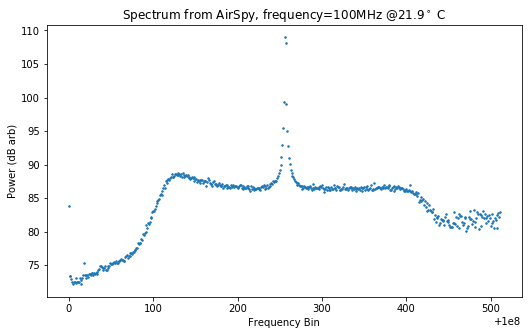

In [89]:
f=np.fft.fft(dry_ice[0:2**19].reshape(-1,1024),axis=1 )
s=(f.real**2+f.imag**2).sum(axis=0)

def plot_spectrum(data, filename, title, directory='graphs/spectrums/'):
    plt.figure(figsize=pagewidth)
    plt.scatter(np.arange(512)+100*10**6,10*np.log10(s[:512]), s=1.5**2)
    plt.xlabel('Frequency Bin')
    plt.ylabel('Power (dB arb)')
    plt.title('Spectrum from AirSpy, frequency='+title)
    plt.savefig(directory+filename+'.png', bbox_inches='tight')

plot_spectrum(room_fm, filenames[1], titles[1])